# Bayesian Model Example - Homelessness

Basic question: have we seen a rise in homelessness in the UK in recent years? 
 

## Data

Homelessness data are available from the [UK government](https://www.gov.uk/government/statistical-data-sets/live-tables-on-homelessness#homelessness-summary-local-authority-level-tables). Here we use Table 1 from the [Rough sleeping statistics England autumn 2017: tables 1, 2a, 2b and 2c](https://www.gov.uk/government/uploads/system/uploads/attachment_data/file/682006/Tables_1_and_2a_2b_2c_-_revised.xlsx) spreadsheet. I downloaded those data and made a simple

Text(0.5,1,'Estimate of rough sleeping in England (by street counting)')

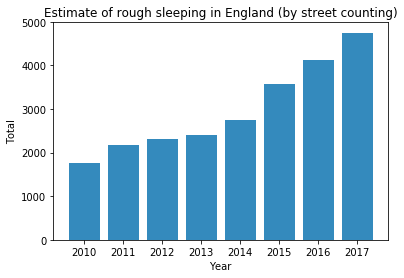

In [37]:
import numpy as np
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt


data = np.array( [[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], \
           [1768, 2181, 2309, 2414, 2744, 3569, 4134, 4751]])

plt.bar(x=data[0,], height=data[1,], color="#348ABD")
plt.xlabel("Year")
plt.ylabel("Total")
plt.title("Estimate of rough sleeping in England (by street counting)")

## Model

We need a model of the data (i.e. a function to represent the homelessness count given the year). Lets assume that it has been increasing linearly, so create a model of the form:

$$ C_i = R x_i + A $$

Where $C_i$ is the homelessness count, for year $i$, $R$ is the rate of change of homelessness, and $A$ is the intercept.

Now we need prior distributions for our $R$ and $A$ variables. They are continuous, and might be negative, so assume that they are normally distributed with $\mu$ and $\tau$:

$$R \sim N(\mu_R, 1/\tau_R)$$

$$A \sim N(\mu_A, 1/\tau_A)$$

The posterior distribution of $R$ will give us an estimate as to whether homelessness has been increasing.

In [39]:
# Simple y=mx+c funcion to model the data.
def func (year, rate, intercept):
    return ( year * rate ) + intercept

Now use MCMC to model the data.

Set up the variables

In [70]:
import pymc3 as pm
import theano.tensor as tt

#year  = data[0,]
year  = np.arange(len(data[0,]))
count = data[1,]

with pm.Model() as model:
    # The two parameters, rate (R) and intercept (A)
    R = pm.Normal("R", mu=0, tau=0.001, testval=0)
    A = pm.Normal("A", mu=0, tau=0.001, testval=0)
    
    # The model (function) that estimates the count C
    func = pm.Deterministic("func", R * year + A)
    
    # Now the observed data. Assume they are Normal as well.
    # XXXX Correctly link to 'func' here?
    obs = pm.Normal('obs', mu=func, tau=0.001, observed=count)
  
    
    

Model the data

In [71]:
with model:
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, start=start, njobs=4)
    burned_trace = trace[100000::2]


logp = -1,279.8, ||grad|| = 3.57e-08: 100%|██████████| 12/12 [00:00<00:00, 890.94it/s]  
100%|██████████| 120500/120500 [00:37<00:00, 3193.36it/s]


See what happened!

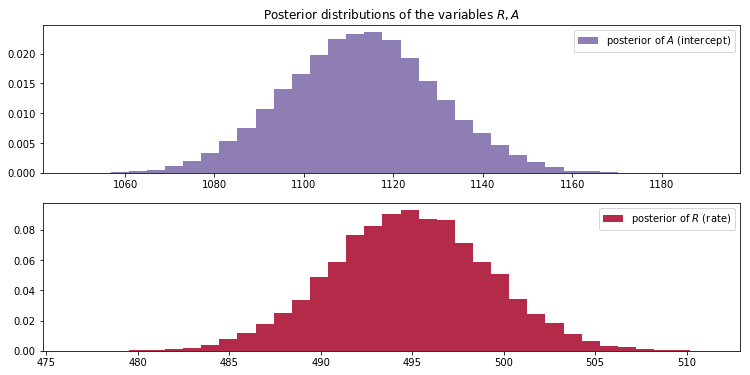

In [65]:
r_samples = burned_trace["R"][:, None]  # best to make them 1d
a_samples = burned_trace["A"][:, None]

figsize(12.5, 6)

#histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $R, A$")
plt.hist(a_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $A$ (intercept)", color="#7A68A6", normed=True)
plt.legend()

plt.subplot(212)
plt.hist(r_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $R$ (rate)", color="#A60628", normed=True)
plt.legend();

Plot the model estimates on the graph

In [60]:
from scipy.stats.mstats import mquantiles

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");


array([0, 1, 2, 3, 4, 5, 6, 7])